In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from numpy import sqrt
import os
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# path = 'COVID-19'
# if not os.path.exists(path):
#   !git clone https://github.com/CSSEGISandData/COVID-19.git
# else:
#   print("Dude!! This file is already download")

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<function matplotlib.pyplot.show>

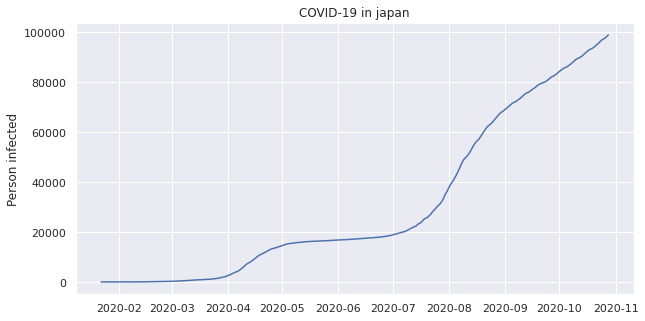

In [7]:
df = pd.read_csv('/content/drive/MyDrive/COVID-19/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region'] == 'Japan']
#df
df = df.iloc[:,4:]#.copy()#copy()をつかはないと代入前のデータも削ってしまう。
#print(df)
daily_japan=df.iloc[0,:]
#print(daily_japan)
daily_japan.index = pd.to_datetime(daily_japan.index)
#print(daily_japan)
daily_japan = daily_japan['2020-01-22':'2020-10-28']

sns.set()
plt.figure(figsize=(10, 5))
plt.plot(daily_japan)
plt.title('COVID-19 in japan')
plt.grid(True)
plt.ylabel('Person infected')
plt.show

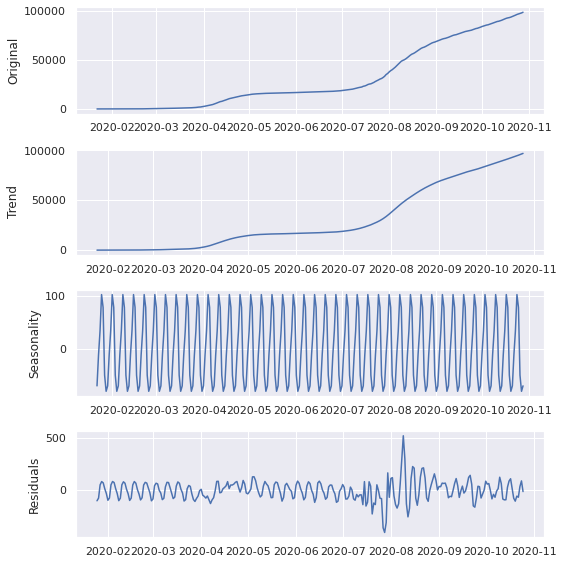

In [8]:
res = seasonal_decompose(daily_japan, freq=7)#データを分解

original = daily_japan # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [9]:
# ADF検定 https://www.medi-08-data-06.work/entry/non_stationary_process
res_ctt = adfuller(daily_japan, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = adfuller(daily_japan, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = adfuller(daily_japan, regression="c") # トレンド項なし、定数項あり
res_nc = adfuller(daily_japan, regression="nc") # トレンド項なし、定数項なし

print("ctt:"+str(res_ctt[1]))
print("ct:"+str(res_ct[1]))
print("c:"+str(res_c[1]))
print("nc:"+str(res_nc[1]))

ctt:0.4220612270038131
ct:0.9490383197944954
c:0.9979062379656886
nc:0.9941130174610655


出力結果の2番目の値がp値です。ADF検定ではでデータが単位根過程であることが帰無仮説になっていているので、棄却することができればデータが単位根過程でない、つまり定常であると判断できます。

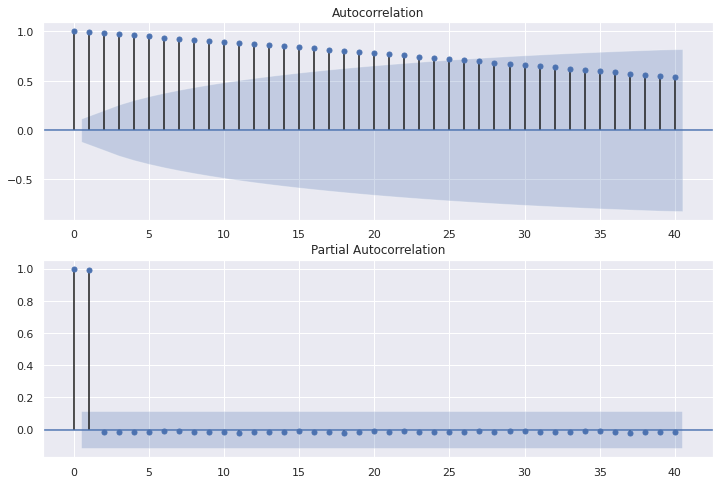

In [10]:
# 自己相関(ACF)のグラフ自動作成
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(daily_japan, lags = 40, ax=ax1); #飛行機乗客数データ、ラグ40、グラフaxes
# 自己相関(ACF)のグラフ自動作成
#fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
plot_pacf(daily_japan, lags = 40, ax=ax2); #飛行機乗客数データ、ラグ40、グラフaxes

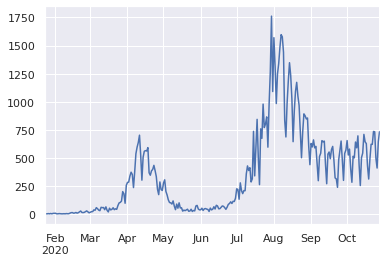

In [11]:
daily_japan_diff = daily_japan.diff().dropna() # 1個できるNaNデータは捨てる
daily_japan_diff.plot()

In [12]:
daily_japan_diff_train = daily_japan_diff.copy()[:-7]
test_data = daily_japan_diff.copy()[-7:]

In [13]:
# ADF検定 https://www.medi-08-data-06.work/entry/non_stationary_process
res_ctt = adfuller(daily_japan_diff_train, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = adfuller(daily_japan_diff_train, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = adfuller(daily_japan_diff_train, regression="c") # トレンド項なし、定数項あり
res_nc = adfuller(daily_japan_diff_train, regression="nc") # トレンド項なし、定数項なし

print("ctt:"+str(res_ctt[1]))
print("ct:"+str(res_ct[1]))
print("c:"+str(res_c[1]))
print("nc:"+str(res_nc[1]))

ctt:0.4144904392018792
ct:0.20550050606687859
c:0.218281992595992
nc:0.2032532373697244


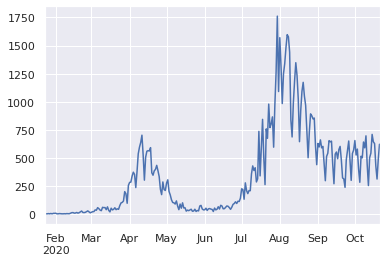

In [14]:
daily_japan_diff_train.plot()

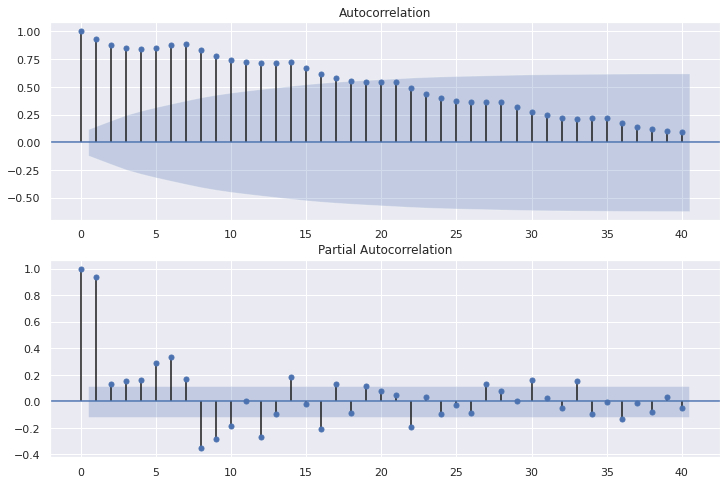

In [15]:
# 自己相関(ACF)のグラフ自動作成
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(daily_japan_diff_train, lags = 40, ax=ax1); #飛行機乗客数データ、ラグ40、グラフaxes
# 自己相関(ACF)のグラフ自動作成
#fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
plot_pacf(daily_japan_diff_train, lags = 40, ax=ax2); #飛行機乗客数データ、ラグ40、グラフaxes

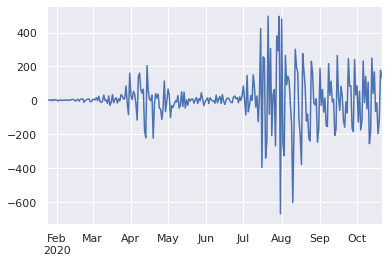

In [16]:
daily_japan_diff2_train = daily_japan_diff_train.diff().dropna()
daily_japan_diff2_train.plot()

In [17]:
# ADF検定 https://www.medi-08-data-06.work/entry/non_stationary_process
res_ctt = adfuller(daily_japan_diff2_train, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = adfuller(daily_japan_diff2_train, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = adfuller(daily_japan_diff2_train, regression="c") # トレンド項なし、定数項あり
res_nc = adfuller(daily_japan_diff2_train, regression="nc") # トレンド項なし、定数項なし

print("ctt:"+str(res_ctt[1]))
print("ct:"+str(res_ct[1]))
print("c:"+str(res_c[1]))
print("nc:"+str(res_nc[1]))

ctt:0.22730288072699195
ct:0.09547017965942128
c:0.02345112577288323
nc:0.0017567637973155568


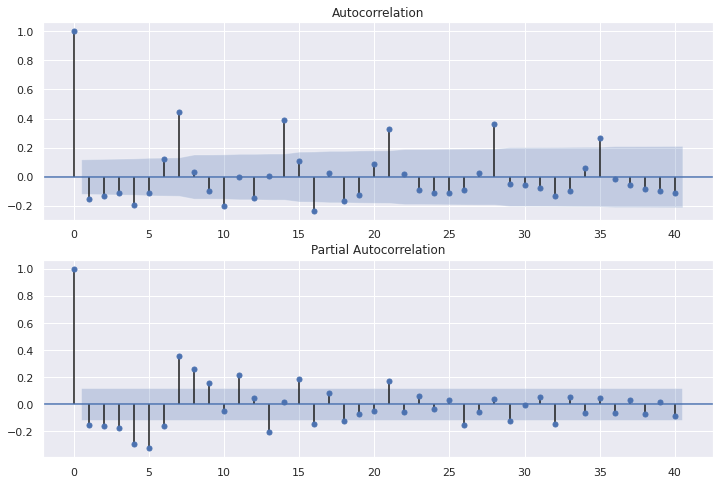

In [18]:
# 自己相関(ACF)のグラフ自動作成
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(daily_japan_diff2_train, lags = 40, ax=ax1); #飛行機乗客数データ、ラグ40、グラフaxes
#plt.show() # インライン表示で同じグラフが2個出でるので回避
# 自己相関(ACF)のグラフ自動作成
#fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
plot_pacf(daily_japan_diff2_train,lags = 40, ax=ax2); #飛行機乗客数データ、ラグ40、グラフaxes

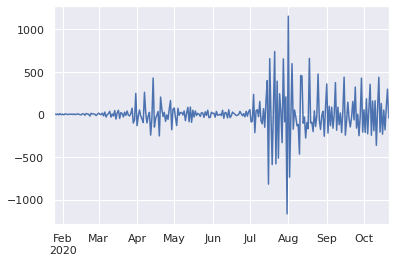

In [19]:
daily_japan_diff3_train = daily_japan_diff2_train.diff().dropna()
daily_japan_diff3_train.plot()

In [20]:
# ADF検定 https://www.medi-08-data-06.work/entry/non_stationary_process
res_ctt = adfuller(daily_japan_diff3_train, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = adfuller(daily_japan_diff3_train, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = adfuller(daily_japan_diff3_train, regression="c") # トレンド項なし、定数項あり
res_nc = adfuller(daily_japan_diff3_train, regression="nc") # トレンド項なし、定数項なし

print("ctt:"+str(res_ctt[1]))
print("ct:"+str(res_ct[1]))
print("c:"+str(res_c[1]))
print("nc:"+str(res_nc[1]))

ctt:1.0646892004351826e-06
ct:1.7025326401399813e-07
c:9.94767349050919e-09
nc:6.256740228916162e-10


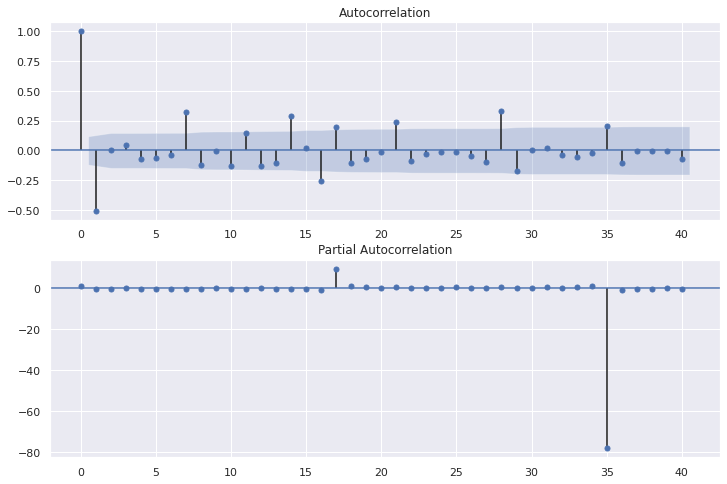

In [21]:
# 自己相関(ACF)のグラフ自動作成
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(daily_japan_diff3_train, lags=40 , ax=ax1); #飛行機乗客数データ、ラグ40、グラフaxes
#plt.show() # インライン表示で同じグラフが2個出でるので回避
# 自己相関(ACF)のグラフ自動作成
#fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
plot_pacf(daily_japan_diff3_train, lags=40,ax=ax2); #飛行機乗客数データ、ラグ40、グラフaxes
#plt.show() # インライン表示で同じグラフが2個出でるので回避

In [ ]:
# 自動ARMAパラメータ推定関数
res_selection = arma_order_select_ic(daily_japan_diff2_train, max_ar=12, max_ma=7, ic='aic', trend='nc')
res_selection

{'aic':               0            1  ...            6            7
 0           NaN  3446.988412  ...  3380.476820  3364.661224
 1   3451.480876  3428.041591  ...  3377.323880  3350.816515
 2   3446.205500  3424.520521  ...  3352.594119  3352.263660
 3   3439.962128  3418.632972  ...  3345.645491  3347.051430
 4   3417.804595  3403.527690  ...  3341.967683  3348.031948
 5   3390.787724  3390.876599  ...  3327.698046  3337.648835
 6   3386.258567  3372.158190  ...  3323.477544  3317.301357
 7   3352.072658  3331.667017  ...  3318.889927  3316.388961
 8   3335.983691  3332.598754  ...  3316.781609  3317.045389
 9   3332.054366  3325.525094  ...  3310.010112  3308.067264
 10  3333.190461  3335.764092  ...          NaN          NaN
 11  3324.905831  3326.816067  ...          NaN          NaN
 12  3326.635276  3325.402376  ...          NaN          NaN
 
 [13 rows x 8 columns], 'aic_min_order': (9, 5)}

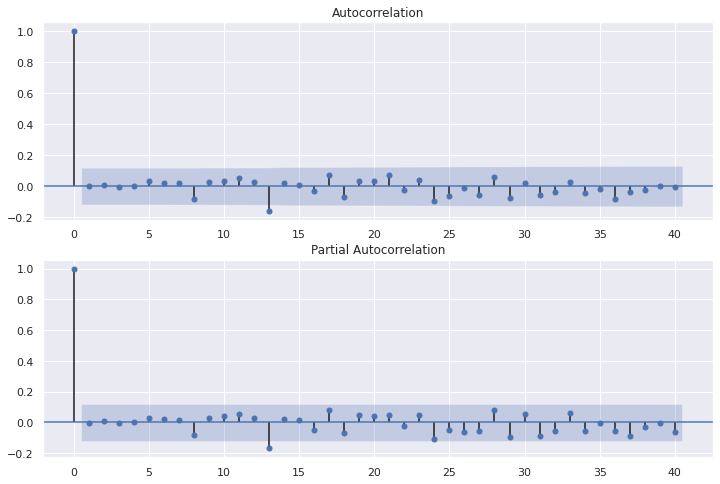

In [22]:
# SRIMAモデル（試しに）季節調整なし = ARIMAモデル
arima = SARIMAX(daily_japan_diff_train, 
                        order=(9, 1, 5),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity = True,
                        enforce_invertibility = True
                        ).fit()

arima_resid = arima.resid # 残差成分

# 自己相関(ACF)のグラフ自動作成
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
plot_acf(arima_resid, lags=40 , ax=ax1); #飛行機乗客数データ、ラグ40、グラフaxes

# 自己相関(ACF)のグラフ自動作成
#fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
plot_pacf(arima_resid, lags=40,ax=ax2); #飛行機乗客数データ、ラグ40、グラフaxes

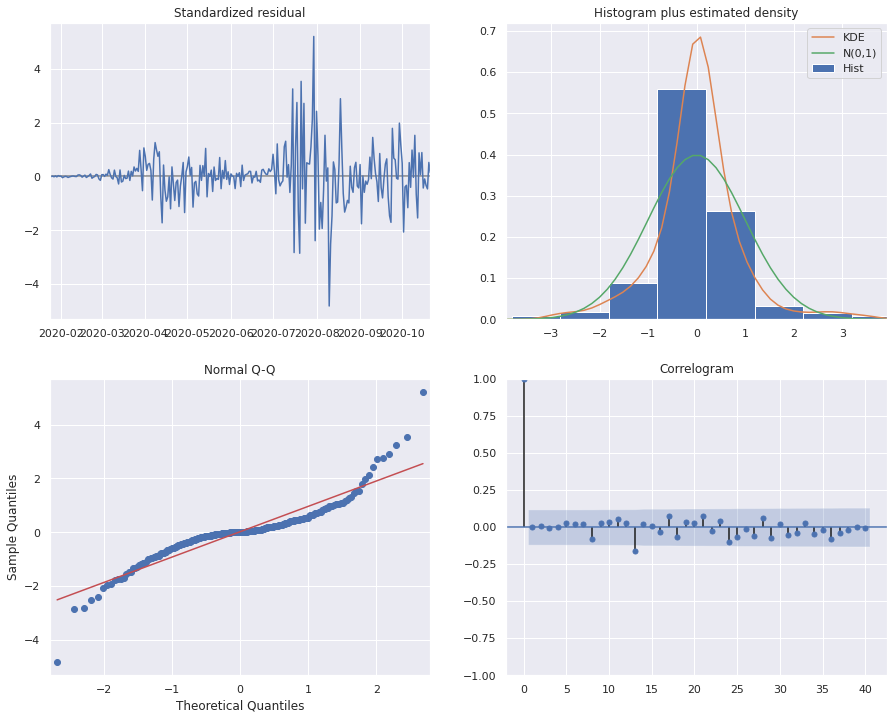

In [25]:
arima.plot_diagnostics(figsize=(15,12),lags=40);

<function matplotlib.pyplot.show>

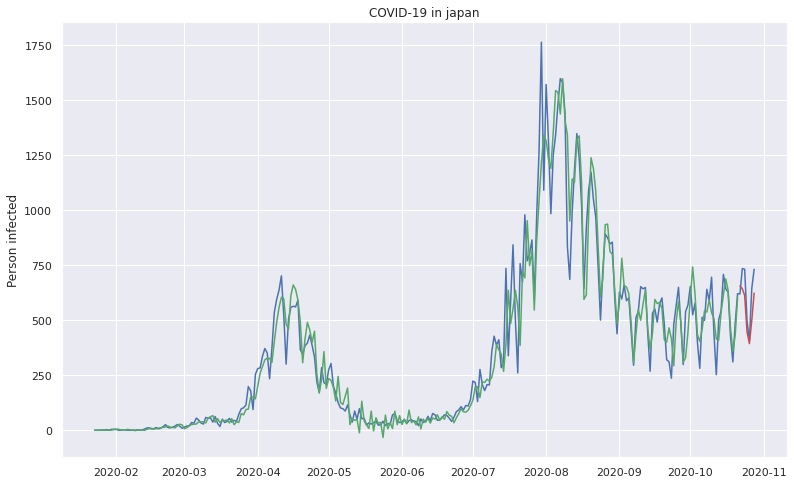

In [32]:
plt.figure(figsize=(13, 8))
plt.plot(daily_japan_diff)
arima_pred_train = arima.predict('2020-01-23', '2020-10-21')
plt.plot(arima_pred_train, c="g")
arima_pred = arima.predict('2020-10-22', '2020-10-28') 
plt.plot(arima_pred, c="r")
#arima_eval = arima.predict('2020-10-15', '2020-10-21') 
#plt.plot(arima_eval, c="g")

plt.title('COVID-19 in japan')
plt.grid(True)
plt.ylabel('Person infected')
plt.show

In [28]:
train_mae_arima = mean_absolute_error(daily_japan_diff_train, arima_pred_train)
train_mse_arima = mean_squared_error(daily_japan_diff_train, arima_pred_train)
train_rmse_arima = np.sqrt(mean_squared_error(daily_japan_diff_train, arima_pred_train))
train_r2_arima = r2_score(daily_japan_diff_train, arima_pred_train)

test_mae_arima = mean_absolute_error(test_data, arima_pred)
test_mse_arima = mean_squared_error(test_data, arima_pred)
test_rmse_arima = np.sqrt(mean_squared_error(test_data, arima_pred))
test_r2_arima = r2_score(test_data, arima_pred)

print('train_mae:'+str(train_mae_arima))
print('train_mse:'+str(train_mse_arima))
print('train_rmae:'+str(train_rmse_arima))
print('train_r2:'+str(train_r2_arima))
print('')
print('test_mae:'+str(test_mae_arima))
print('test_mse:'+str(test_mse_arima))
print('test_rmse:'+str(test_rmse_arima))
print('test_r2:'+str(test_r2_arima))

train_mae:59.808316531962525
train_mse:9833.13721626019
train_rmae:99.16217633886517
train_r2:0.9301527613726231

test_mae:80.59909845525816
test_mse:8472.999360207965
test_rmse:92.04889657246287
test_r2:0.3973614686932958


In [ ]:
# パラメータ範囲
# order(p, d, q)
min_p = 1; max_p = 3 # min_pは1以上を指定しないとエラー
min_d = 0; max_d = 2
min_q = 0; max_q = 3

# seasonal_order(sp, sd, sq)
min_sp = 0; max_sp = 3
min_sd = 0; max_sd = 2
min_sq = 0; max_sq = 3

test_pattern = (max_p - min_p +1)*(max_q - min_q + 1)*(max_d - min_d + 1)*(max_sp - min_sp + 1)*(max_sq - min_sq + 1)*(max_sd - min_sd + 1)
print("pattern:", test_pattern)

sfq = 7 # seasonal_order周期パラメータ
ts = daily_japan_diff_train # 時系列データ

test_results = pd.DataFrame(index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
start_time = time.time()
for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        try:
                            sarima = SARIMAX(
                                ts, order=(p, d, q), 
                                seasonal_order=(sp, sd, sq, sfq), 
                                enforce_stationarity = True, 
                                enforce_invertibility = True,
                            ).fit()
                            test_results.iloc[num]["model_parameters"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), seasonal_order=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                            test_results.iloc[num]["aic"] = sarima.aic
                            #print(num,'/', test_pattern-1, test_results.iloc[num]["model_parameters"],  test_results.iloc[num]["aic"] )
                            num = num + 1
                        except:
                            continue
print("探索時間:",time.time() - start_time)
# 結果（最小AiC）
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])
#print(test_results.sort_values(by='aic').head(10)) # aic top10

pattern: 1728
0 / 1727 order=(1,0,0), seasonal_order=(0,0,0) 3467.980561945906
1 / 1727 order=(1,0,0), seasonal_order=(0,0,1) 3429.5661794847992
2 / 1727 order=(1,0,0), seasonal_order=(0,0,2) 3410.1977538915144
3 / 1727 order=(1,0,0), seasonal_order=(0,0,3) 3405.749378443408
4 / 1727 order=(1,0,0), seasonal_order=(0,1,0) 3356.223847735574
5 / 1727 order=(1,0,0), seasonal_order=(0,1,1) 3289.66725081095
6 / 1727 order=(1,0,0), seasonal_order=(0,1,2) 3289.6418656696706
7 / 1727 order=(1,0,0), seasonal_order=(0,1,3) 3289.689663362607
8 / 1727 order=(1,0,0), seasonal_order=(0,2,0) 3494.9561783502486
9 / 1727 order=(1,0,0), seasonal_order=(0,2,1) 3301.374193180224
10 / 1727 order=(1,0,0), seasonal_order=(0,2,2) 3248.990574221449
11 / 1727 order=(1,0,0), seasonal_order=(0,2,3) 3249.3781897352555
12 / 1727 order=(1,0,0), seasonal_order=(1,0,0) 3402.040186140207
13 / 1727 order=(1,0,0), seasonal_order=(1,0,1) 3370.7825684635727
14 / 1727 order=(1,0,0), seasonal_order=(1,0,2) 3372.4958327327804


In [ ]:
test_results.sort_values(by='aic').head(10) # aic top10

,model_parameters,aic
1427,"order=(3,1,2), seasonal_order=(0,2,3)",3196.73
320,"order=(1,1,2), seasonal_order=(2,2,2)",3202.9
308,"order=(1,1,2), seasonal_order=(1,2,2)",3202.96
321,"order=(1,1,2), seasonal_order=(2,2,3)",3203.82
918,"order=(2,1,3), seasonal_order=(1,2,3)",3206.19
260,"order=(1,1,1), seasonal_order=(1,2,2)",3206.84
356,"order=(1,1,3), seasonal_order=(1,2,2)",3207.09
297,"order=(1,1,2), seasonal_order=(0,2,3)",3207.24
494,"order=(1,2,2), seasonal_order=(1,2,2)",3207.71
296,"order=(1,1,2), seasonal_order=(0,2,2)",3208.99


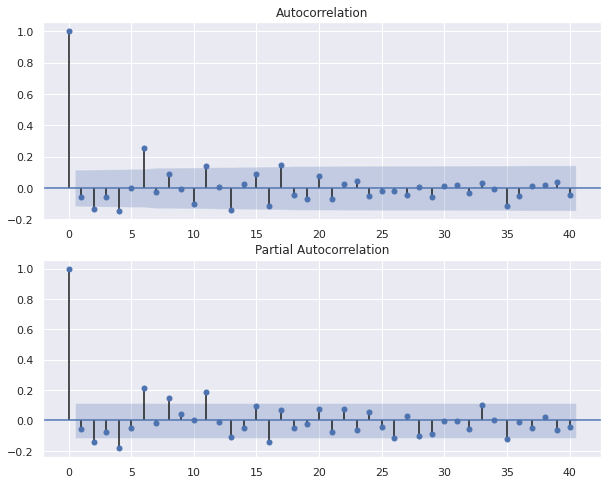

In [26]:
# SRIMAモデル（ちょっとだけパラメータ最適化・総当たりaicベストを適用）
sarima = SARIMAX(daily_japan_diff, 
                        order=(3, 1, 2),
                        seasonal_order=(0, 2, 3, 7),
                        enforce_stationarity = True, 
                        enforce_invertibility = True
                        ).fit()

sarima_resid = sarima.resid # 残差成分

fig = plt.figure(figsize=(10,8))
# 自己相関のコレログラム
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(sarima_resid, lags=40, ax=ax1);
# 偏自己相関のコレログラム
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(sarima_resid, lags=40, ax=ax2);
#plt.savefig(filename,bbox_inches='tight', pad_inches=0.2)
#plt.show()

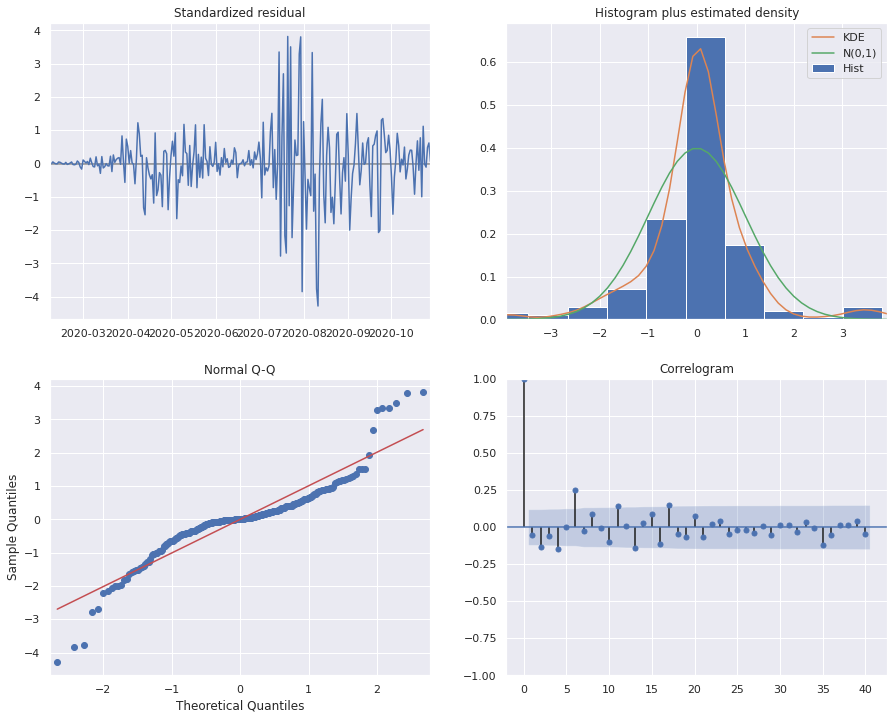

In [27]:
sarima.plot_diagnostics(figsize=(15,12),lags=40);

<function matplotlib.pyplot.show>

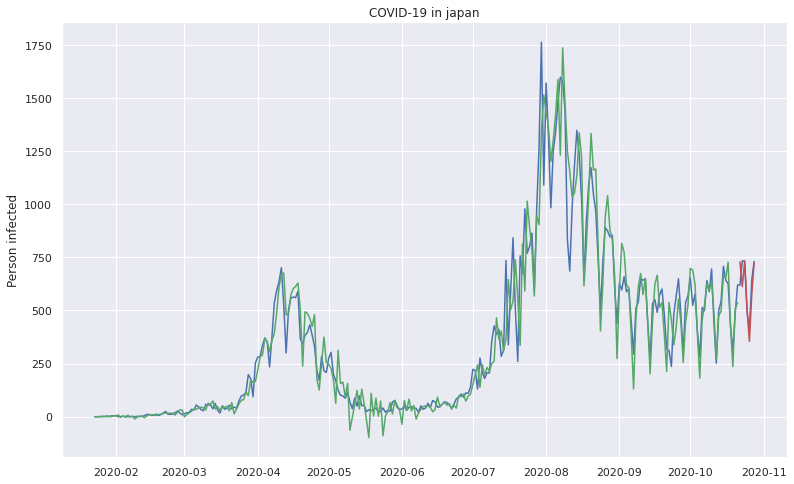

In [33]:
plt.figure(figsize=(13, 8))
plt.plot(daily_japan_diff)
sarima_pred_train = sarima.predict('2020-01-23', '2020-10-21')
plt.plot(sarima_pred_train, c="g")
sarima_pred = sarima.predict('2020-10-22', '2020-10-28') 
plt.plot(sarima_pred, c="r")
#arima_eval = arima.predict('2020-10-15', '2020-10-21') 
#plt.plot(arima_eval, c="g")

plt.title('COVID-19 in japan')
plt.grid(True)
plt.ylabel('Person infected')
plt.show

In [34]:
train_mae_sarima = mean_absolute_error(daily_japan_diff_train, sarima_pred_train)
train_mse_sarima = mean_squared_error(daily_japan_diff_train, sarima_pred_train)
train_rmse_sarima = np.sqrt(mean_squared_error(daily_japan_diff_train, sarima_pred_train))
train_r2_sarima = r2_score(daily_japan_diff_train, sarima_pred_train)

test_mae_sarima = mean_absolute_error(test_data, sarima_pred)
test_mse_sarima = mean_squared_error(test_data, sarima_pred)
test_rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_pred))
test_r2_sarima = r2_score(test_data, arima_pred)

print('train_mae:'+str(train_mae_sarima))
print('train_mse:'+str(train_mse_sarima))
print('train_rmae:'+str(train_rmse_sarima))
print('train_r2:'+str(train_r2_sarima))
print('')
print('test_mae:'+str(test_mae_sarima))
print('test_mse:'+str(test_mse_sarima))
print('test_rmse:'+str(test_rmse_sarima))
print('test_r2:'+str(test_r2_sarima))

train_mae:66.17126947091299
train_mse:11967.777095182704
train_rmae:109.39733586876193
train_r2:0.9149898791990616

test_mae:53.279380608827246
test_mse:4922.436242302145
test_rmse:70.16007584304727
test_r2:0.3973614686932958


##Auto_Arimaを使用するなら....
ただし、あまり良いモデルは選ばれないため控えた方が良い

In [ ]:
#! pip install pmdarima

In [ ]:
#! cat /proc/cpuinfo #CPUの確認

In [ ]:
#from pmdarima.arima import auto_arima

# stepwise_model = auto_arima(daily_japan_diff,
#                             start_p=1, d=None, start_q=0,
#                             start_P=0, D=None, start_Q=0,
#                             max_p=1, max_d=1, max_q=1,
#                             max_P=1, max_D=1, max_Q=1,
#                             max_order=None, m=7,
#                             test = 'adf',
#                             seasonal = True, trace=True, #季節性とログを出す
#                             error_action = 'ignore',
#                             stepwise=False, approximation=False, #計算を省くな
#                             n_jobs = 1,#CPUのコア数
#                             )
# stepwise_model.summary()

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3395.232, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=3287.581, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=3333.955, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=3287.681, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=3321.434, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3252.731, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=3282.558, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=3246.714, Time=0.69 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=3344.461, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=3262.224, Time=0.28 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3293.033, Time=0.14 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=3260.004, Time=0.42 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=3323.359, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=3253.227, Time=0.46 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=3284.121, Time=0.27 sec
 ARIMA(1,1

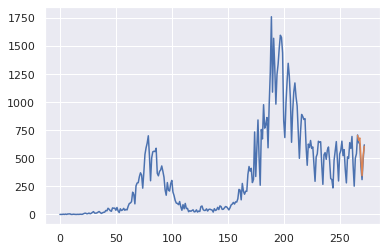

In [ ]:
# print(len(daily_japan_diff)-7)

# predict = stepwise_model.predict(n_periods=7)
# x0=np.arange(len(daily_japan_diff))
# x1=np.arange(len(predict))
# #df = pd.concat(daily_japan_train,predict)
# plt.plot(x0, daily_japan_diff)
# plt.plot(x1+266, predict)

#pltのメモリの角度を変えるなら

In [ ]:
plt.xticks(rotation=90)